In [21]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from collections import Counter
import skimage
from skimage import io
from PIL import Image
import os
import numpy as np
from typing import Callable
from skimage.color import rgb2hsv
from scipy import ndimage

import warnings
warnings.filterwarnings("ignore")

In [2]:
labels = pd.read_csv("dataset/train_labels.csv")
img_name = labels.iloc[0, 0]
features = labels.iloc[80, 1:]
print(img_name)
# print(features)

L1010281


In [3]:
class CoinDataset(Dataset):
    def __init__(self):
        self.labels = pd.read_csv("dataset/train_labels.csv")
        self.root = "dataset/train/"

        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
    
        img_name = os.path.join(self.root, self.labels.iloc[index, 0]+ ".JPG")
        image = io.imread(img_name)
        coins = torch.tensor(self.labels.iloc[index, 1:])
        
        sample = {'image': image, 'coins': coins}
        
        sample = self.transform(sample)
        
        return sample
    
    def transform(self, sample):
        image_og = sample['image'] 

        scale_percent = 25
        width = int(image_og.shape[1] * scale_percent / 100)
        height = int(image_og.shape[0] * scale_percent / 100)
        dim = (width, height)
        image_red = cv2.resize(image_og, dim, interpolation=cv2.INTER_AREA)

        return {'image':image_red, 'coins': sample['coins']}
        

def show_image(image, coins):
    plt.imshow(image.squeeze(0))
    plt.pause(0.001)
    
def show_image_batch(coin_batch):
    images_batch = coin_batch['image']
    coins_batch = coin_batch['coins']
    print(len(images_batch))
    
    for i in range(len(images_batch)):
        ax = plt.subplot(1,4, i+1)
        plt.tight_layout()
        # print(coin_batch[i])
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')
        show_image(images_batch[i], coins_batch[i])
    # grid = utils.make_grid(images_batch)
    # plt.imshow(grid.numpy().transpose((1,2,0)))
    

In [4]:
coin_dataset = CoinDataset()
print(len(coin_dataset))

coin_dataloader = DataLoader(coin_dataset, batch_size=4, shuffle=True, num_workers=0)


81


In [5]:
# for i, sample in enumerate(coin_dataloader):
#     print(i, sample['image'].size(), sample['coins'].size())
#     if i == 3:
#         plt.figure()
#         show_image_batch(sample)
#         plt.axis('off')
#         plt.ioff() 
#         plt.show()
#         break

OG dimensions:  (4000, 6000, 3)
reduced dimensions:  (1400, 2100, 3)


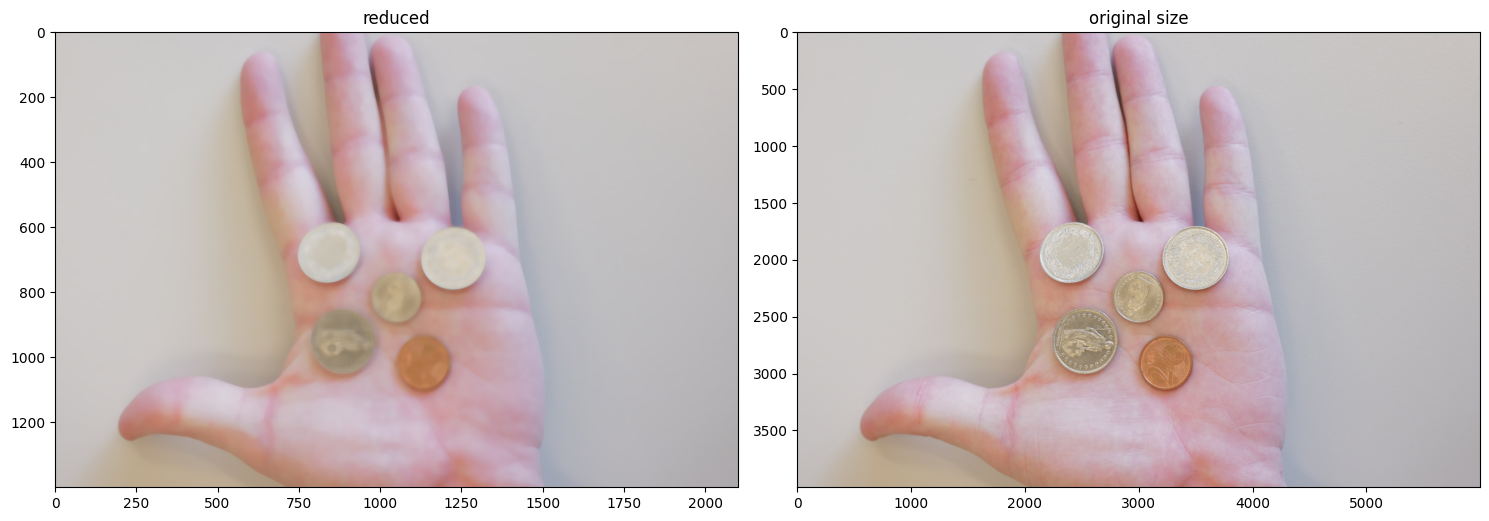

In [171]:
# Define path
path_hand = os.path.join("dataset", "train", "L1010378.JPG") #"L1010521.JPG") #L1010517.JPG") #L1010378.JPG")
path_noisy = os.path.join("dataset", "train", "L1010503.JPG") #"L1010478.JPG") #L1010369.JPG")#"L1010370.JPG")
path_neutral = os.path.join("dataset", "train", "L1010440.JPG") #"L1010413.JPG")#"L1010308.JPG")#"L1010281.JPG") #"L1010422.JPG") #"L1010321.JPG")#"L1010422.JPG") #"L1010434.JPG") #"L1010283.JPG") #"L1010277.JPG")

# Check if folder and image exist
assert os.path.exists(path_hand), "Image not found, please check directory structure"

# Load image
image_hand = np.array(Image.open(path_hand))
image_noisy = np.array(Image.open(path_noisy))
image_neutral = np.array(Image.open(path_neutral))

image_og = image_hand

scale_percent = 35
width = int(image_og.shape[1] * scale_percent / 100)
height = int(image_og.shape[0] * scale_percent / 100)
dim = (width, height)
image = cv2.resize(image_og, dim, interpolation=cv2.INTER_AREA)
image = cv2.medianBlur(image, 19)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("reduced")
plt.subplot(1,2,2)
plt.title("original size")
plt.imshow(image_og)

# plt.axis('off')
plt.tight_layout()
print("OG dimensions: ", image_og.shape)
print("reduced dimensions: ", image.shape)



In [172]:
def extract_rgb_channels(img):
    """
    Extract RGB channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_red: np.ndarray (M, N)
        Red channel of input image
    data_green: np.ndarray (M, N)
        Green channel of input image
    data_blue: np.ndarray (M, N)
        Blue channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for RGB channels
    data_red = np.zeros((M, N))
    data_green = np.zeros((M, N))
    data_blue = np.zeros((M, N))

    # ------------------
    data_red = img[:,:,0]
    data_green = img[:,:,1]
    data_blue = img[:,:,2]
    # ------------------
    
    return data_red, data_green, data_blue

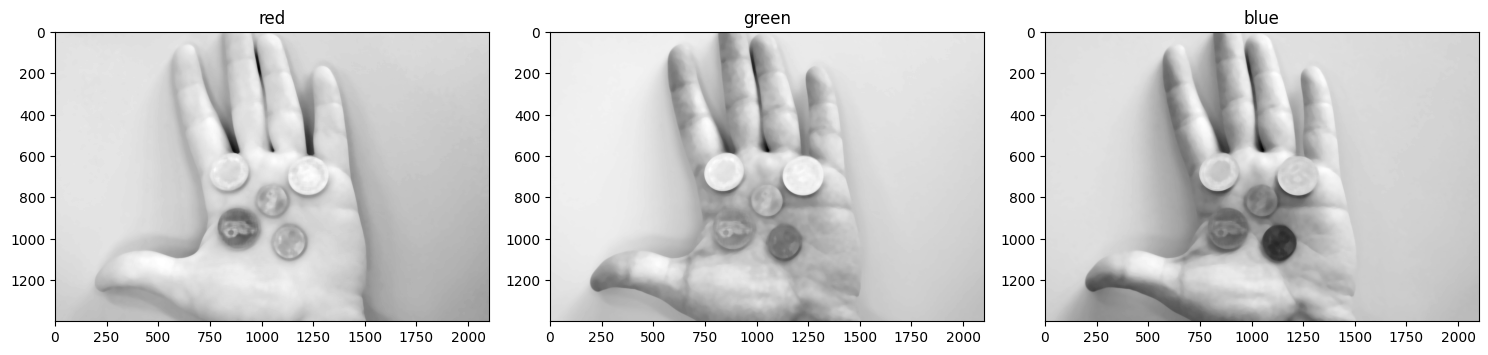

In [173]:
[data_red,data_green,data_blue] = extract_rgb_channels(image)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_red, cmap='gray')
plt.title('red')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_green, cmap='gray')
plt.title('green')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_blue, cmap='gray')
plt.title('blue')

plt.tight_layout()

In [174]:
def apply_rgb_threshold(img):
    """
    Apply threshold to RGB input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    # data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    thr_red = 200      #   Threshold on red
    thr_green = 168      #   Threshold on green
    thr_blue = 154    #   Threshold on blue
    
    mask_red = img[:,:,0] > thr_red     #   Mask computed on red channel
    mask_green = img[:,:,1] > thr_green     #   Mask computed on red channel
    mask_blue = img[:,:,2] > thr_blue       #   Mask computed on red channel

    # img_th = img_red*img_green*img_blue     #   Combine masks for all channels
    img_th = np.logical_not(mask_red*mask_green*mask_blue)
    #
    img_th = np.logical_not(mask_blue*mask_green) #+ mask_red
    img_th = np.logical_not(mask_blue)
    # img_th = np.logical_not(mask_green)
    # ------------------

    return  img_th

def apply_rgb_threshold_hand(img):
    """
    Apply threshold to RGB input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract RGB channels
    # data_red, data_green, data_blue = extract_rgb_channels(img=img)
    
    # ------------------
    thr_red = 200      #   Threshold on red
    thr_green = 170 #175      #   Threshold on green
    thr_blue = 75   #   Threshold on blue
    
    mask_red = img[:,:,0] > thr_red     #   Mask computed on red channel
    mask_green = img[:,:,1] > thr_green     #   Mask computed on red channel
    mask_blue = img[:,:,2] > thr_blue       #   Mask computed on red channel

    # img_th = img_red*img_green*img_blue     #   Combine masks for all channels
    img_th = np.logical_not(mask_red*mask_green*mask_blue)
    # img_th = np.logical_or(mask_green, np.logical_not(mask_blue))
    img_th = mask_green
    # ------------------

    return  img_th

<Figure size 640x480 with 0 Axes>

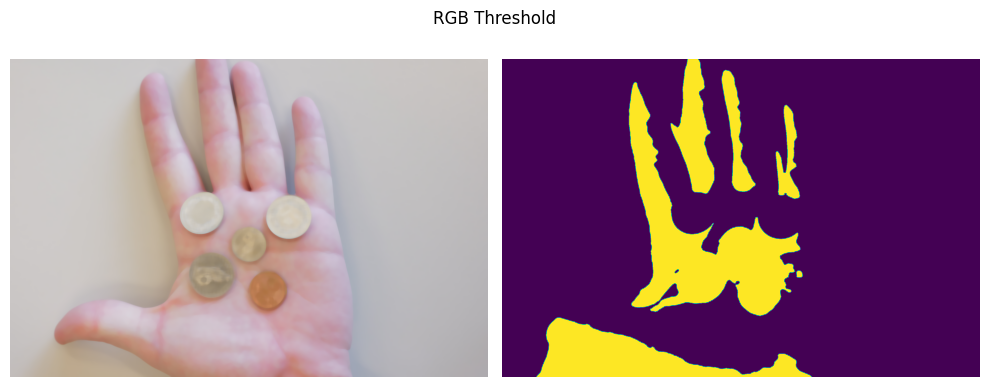

In [175]:
# Plot color space distribution 
def plot_thresholded_image(
    img: np.ndarray,
    func: Callable,
    title: str,
):
    """
    Plot the original image and its thresholded version

    Args
    ----
    img: np.ndarray (M, N, 3)
        Input image of shape MxNx3.
    func: Callable
        Thresholded image.
    title: str
        Title of the plot
    """
    plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(img)
    axes[1].imshow(func(img))
    [a.axis('off') for a in axes]
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
# Plot best RGB thresholding
plot_thresholded_image(img=image, func=apply_rgb_threshold, title="RGB Threshold")

In [176]:
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    hsv_img = rgb2hsv(img)
    data_h = hsv_img[:,:,0]
    data_s = hsv_img[:,:,1]
    data_v = hsv_img[:,:,2]
    # ------------------
    
    return data_h, data_s, data_v

Text(0.5, 1.0, 'value')

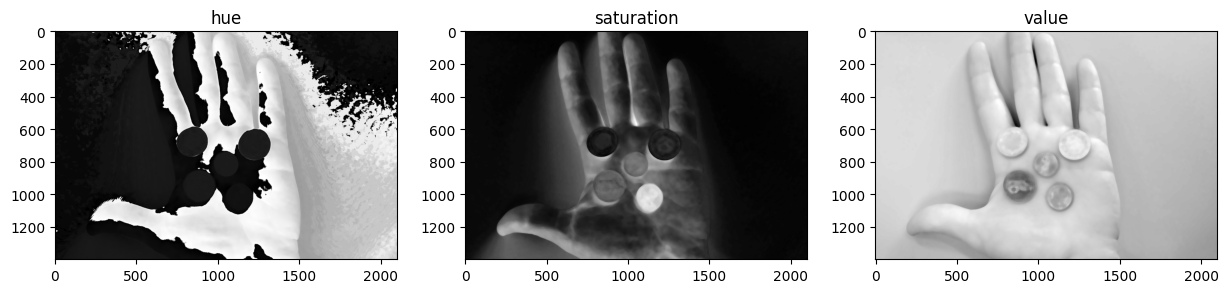

In [177]:
[data_h,data_s,data_v] = extract_hsv_channels(image)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_h, cmap='gray')
plt.title('hue')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_s, cmap='gray')
plt.title('saturation')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_v, cmap='gray')
plt.title('value')


<Figure size 640x480 with 0 Axes>

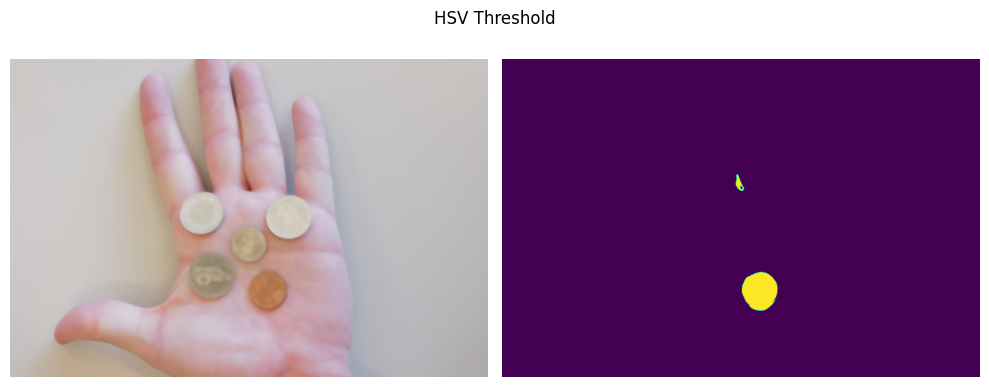

In [207]:
def apply_hsv_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    # thr_hue_l = 0.77    #   Lower threshold on hue
    # thr_hue_u = 0.88    #   Upper threshold on hue
    
    # mask_h_l = data_h[:,:] > thr_hue_l      #   Mask computed on hue lower threshold
    # img_h_l = (mask_h_l)
    # mask_h_u = data_h[:,:] < thr_hue_u      #   Mask computed on hue upper threshold
    # img_h_u = (mask_h_u)
    # combined_hue = img_h_l * img_h_u        #   Mask computed on hue 

    # thr_v = 0.60    #   Threshold on value
    # mask_v = data_v > thr_v         #   Mask computed on value
    # img_v = np.logical_not(mask_v)
    
    thr_s_low = 0.68
    thr_s_up = 0.98 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_s = (mask_s_low)
    
    img_th = img_s  
    mask = data_s < 0.65
    mask_2 = data_v < 0.768
    mask_3 = data_v < 0.7
    img_2 = mask_2#   Thresholded image, a combination of different thresholds results in less noise
    
    # ------------------
    if np.sum(img_th) < 1000:
        # print("case 1")
        if np.sum(np.logical_not(img_2)) > 1000:
            # print(np.sum(np.logical_not(img_2)) )
            # print("subcase 1")
            return img_2
        else:
            # print("subcase 2")
            return mask_3
    return img_th

def apply_hsv_threshold_noisy(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    
    thr_s_low = 0.1
    thr_s_up = 0.3 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_s = (mask_s_low*mask_s_up)
    
    img_th = img_s  
    mask = data_s < 0.65
    mask_2 = data_v < 0.768
    mask_3 = data_v < 0.7
    img_2 = mask_2#   Thresholded image, a combination of different thresholds results in less noise
    
    img_h = data_h < 150
    
    # ------------------

    return img_s

def apply_hsv_threshold_hand(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
    data_h, data_s, data_v = extract_hsv_channels(img=img)
    
    # ------------------
    
    thr_s_low = 0.51
    thr_s_up = 0.65 #   Threshold on saturation
    mask_s_low = data_s > thr_s_low   
    mask_s_up = data_s < thr_s_up#   Mask computed on saturation
    img_s = (mask_s_low*mask_s_up)
    
    img_th = img_s  
    mask = data_s < 0.65
    mask_2 = data_v < 0.768
    mask_3 = data_v < 0.7
    img_2 = mask_2#   Thresholded image, a combination of different thresholds results in less noise
    
    img_h = data_h < 150
    
    # ------------------

    return img_s

plot_thresholded_image(img=image, func=apply_hsv_threshold_hand, title="HSV Threshold")

In [208]:
def extract_LAB_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    LAB_img = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    L = LAB_img[:,:,0]
    A = LAB_img[:,:,1]
    B = LAB_img[:,:,2]
    # ------------------
    
    return L, A, B

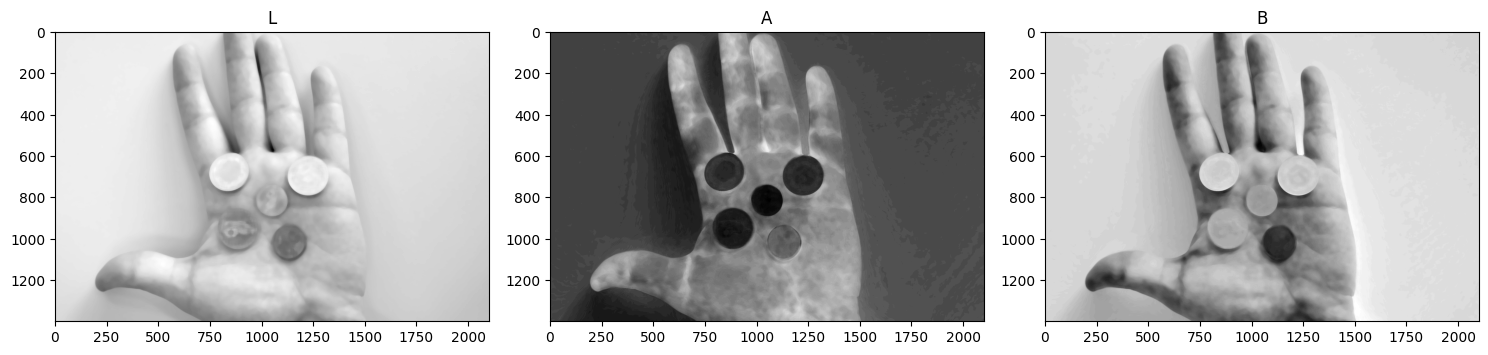

In [209]:
[data_red,data_green,data_blue] = extract_LAB_channels(image)

# Create subplots
plt.figure(figsize=(15, 5))

# Plot the first image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, plot 1
plt.imshow(data_red, cmap='gray')
plt.title('L')

# Plot the second image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, plot 2
plt.imshow(data_green, cmap='gray')
plt.title('A')

# Plot the third image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, plot 3
plt.imshow(data_blue, cmap='gray')
plt.title('B')

plt.tight_layout()

In [210]:
def apply_LAB_threshold(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
        
    # ------------------

    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    thr_L = 100      #   Threshold on red
    thr_A = 130      #   Threshold on green
    thr_B = 0      #   Threshold on blue
    
    # mask_L = LAB_img[:,:,0] > thr_L     #   Mask computed on red channel
    mask_A = LAB_img[:,:,1] > thr_A     #   Mask computed on red channel
    mask_B = LAB_img[:,:,2] > thr_B
    
    # img_th = img_red*img_green*img_blue     #   Combine masks for all channels
    # img_th = (mask_red*mask_green*mask_blue)
    img_th = np.logical_not(mask_A) 
    
    # ------------------
    return  img_th

def apply_LAB_threshold_noisy(img):
    """
    Apply threshold to the input image in hsv colorspace.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    img_th: np.ndarray (M, N)
        Thresholded image.
    """

    # Define the default value for the input image
    M, N, C = np.shape(img)
    img_th = np.zeros((M, N))

    # Use the previous function to extract HSV channels
        
    # ------------------

    LAB_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    thr_L = 206 #   Threshold on red
    thr_A = 99      #   Threshold on green
    thr_B = 107 #106     #   Threshold on blue
    
    mask_L_low = LAB_img[:,:,0] > thr_L 
    mask_L_up = LAB_img[:,:,0] < 225    #   Mask computed on red channel
#   Mask computed on red channel
    mask_A = LAB_img[:,:,1] > thr_A     #   Mask computed on red channel
    mask_B = LAB_img[:,:,2] > thr_B       #   Mask computed on red channel

    # img_th = img_red*img_green*img_blue     #   Combine masks for all channels
    # img_th = (mask_red*mask_green*mask_blue)
    img_th = np.logical_or(np.logical_not(mask_B),mask_L_low*mask_L_up)
    img_th = np.logical_not(mask_B)
    # ------------------
    return  img_th



<Figure size 640x480 with 0 Axes>

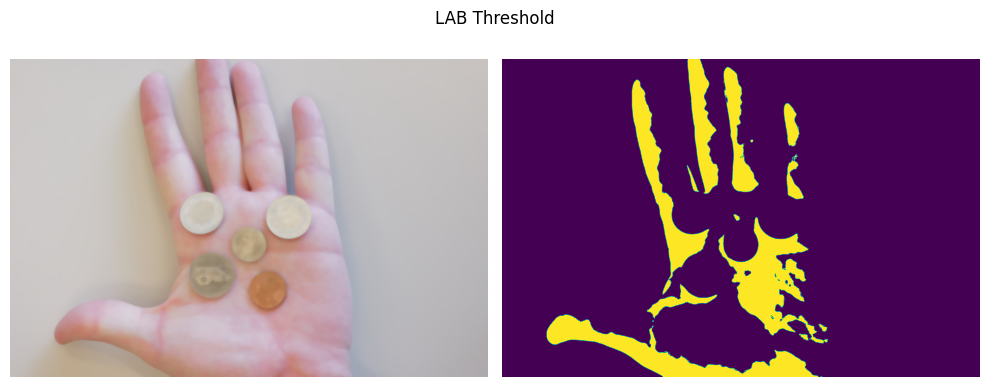

In [211]:
plot_thresholded_image(img=image, func=apply_LAB_threshold_noisy, title="LAB Threshold")

In [212]:
def apply_threshold(img):
    image_blurred = cv2.medianBlur(img, 9)
    background = find_background(img)
    
    if detect_netural(img) and background[0] > 180:
        print("neutral")
        img_rgb = apply_rgb_threshold(image_blurred)
        img_hsv = apply_hsv_threshold_hand(image_blurred)
        if np.sum(np.logical_not(img_hsv)) < 5000:
            img_th = img_rgb
        else:
            img_th = img_rgb + img_hsv
    elif detect_hand(img) and background[0] > 180:
        print("hand")
        img_th = np.logical_or(apply_LAB_threshold(img), apply_hsv_threshold_hand(img)) #np.logical_or(apply_rgb_threshold_hand(img), apply_hsv_threshold_hand(img)) #*(hand)
    else:
        print("noisy")
        img_th = apply_LAB_threshold_noisy(img)
   
    return img_th

def detect_netural(img):
    # https://stackoverflow.com/questions/58668245/how-to-quickly-and-efficiently-check-if-an-image-is-mostly-background
    h,w, _ = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1]
    pixels = cv2.countNonZero(thresh)
    ratio = pixels/(h*w) * 100
    return ratio < 10

def detect_hand(img):
    h,w, _ = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY_INV)[1]
    pixels = cv2.countNonZero(thresh)
    ratio = pixels/(h*w) * 100    
    return (ratio < 30)

def find_background(img):
    # https://umarmasud07.medium.com/easiest-approach-for-background-colour-detection-5914217da325
    blue,green,red=cv2.split(img)
    blue=blue.flatten()
    green=green.flatten()
    red=red.flatten()
    blue_counter=Counter(blue)
    green_counter=Counter(green)
    red_counter=Counter(red)
    blue_most=blue_counter.most_common(10)
    blue_avg=[i for i,j in blue_most]
    blue_avg=int(np.mean(blue_avg))
 
    green_most=green_counter.most_common(10)
    green_avg=[i for i,j in green_most]
    green_avg=int(np.mean(green_avg))
    red_most=red_counter.most_common(10)
    red_avg=[i for i,j in red_most]
    red_avg=int(np.mean(red_avg))
    background=[blue_avg,green_avg,red_avg]
    return(background)


hand


<Figure size 640x480 with 0 Axes>

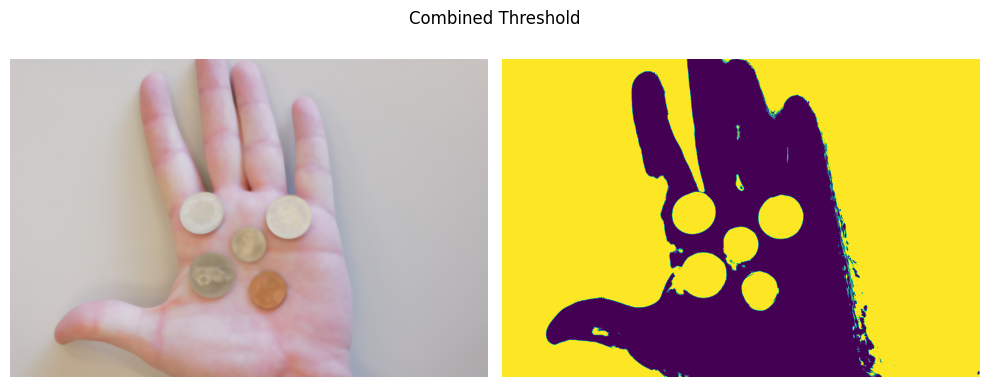

In [213]:
plot_thresholded_image(img=image, func=apply_threshold, title="Combined Threshold")

[73, 12, 15, 20, 54]
73 L1010470
noisy


<Figure size 640x480 with 0 Axes>

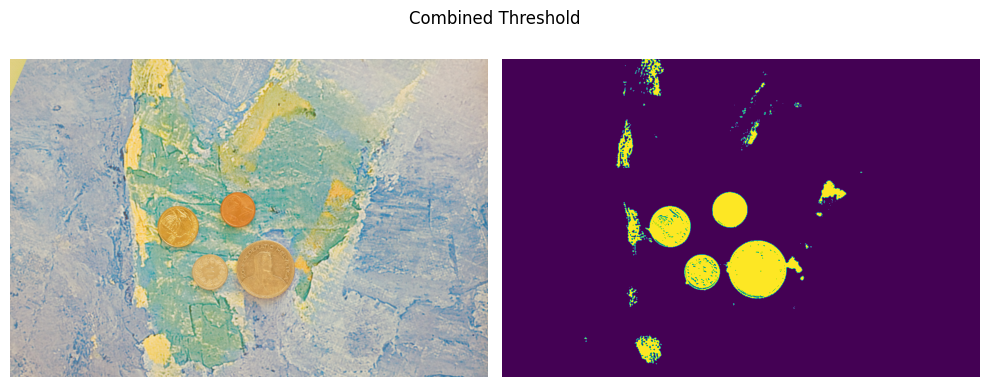

12 L1010311
neutral


<Figure size 640x480 with 0 Axes>

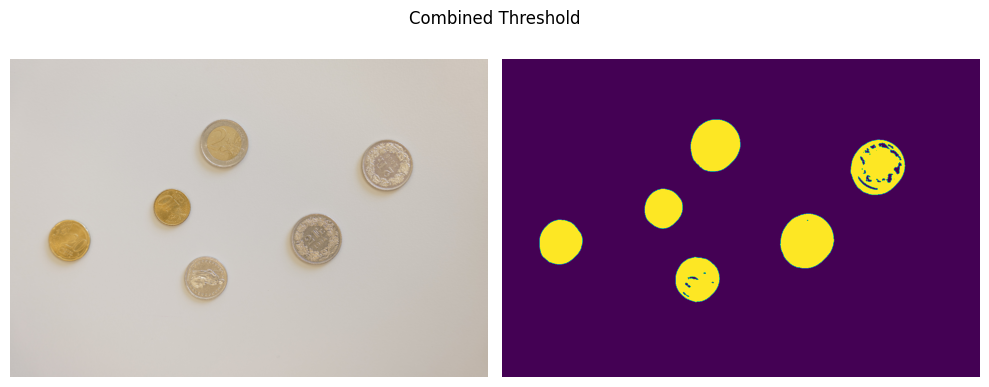

15 L1010283
neutral


<Figure size 640x480 with 0 Axes>

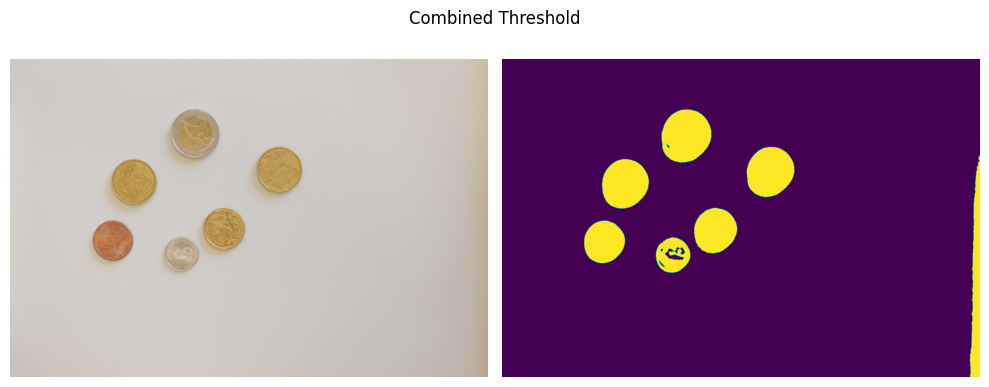

20 L1010370
noisy


<Figure size 640x480 with 0 Axes>

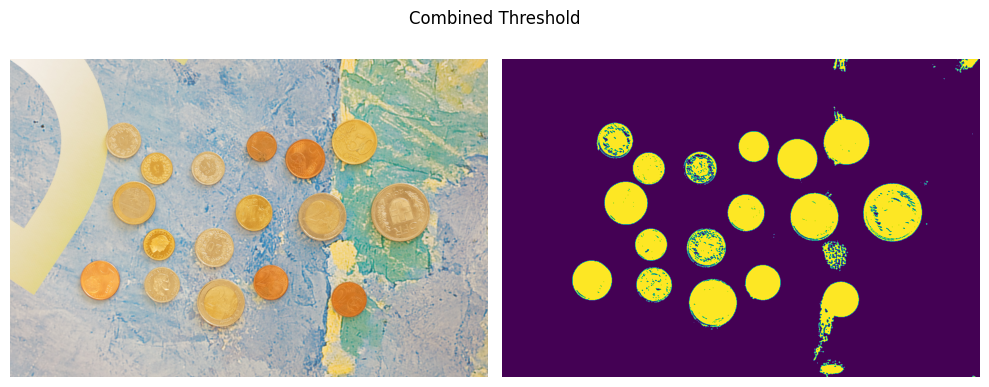

54 L1010445
neutral


<Figure size 640x480 with 0 Axes>

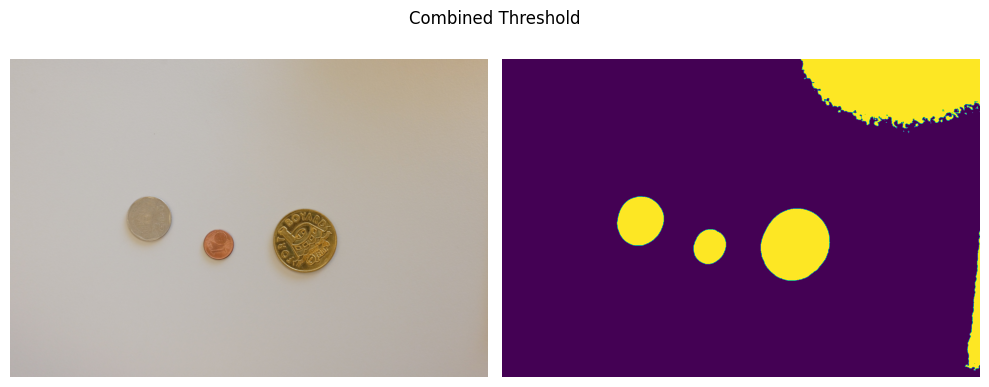

In [215]:
import random
list = random.sample(range(0,80),5)
print(list)

for i in list:
    print(i, coin_dataset.labels.iloc[i, 0])
    plot_thresholded_image(img=coin_dataset[i]['image'], func=apply_threshold, title="Combined Threshold")

In [216]:
def apply_morphology(img_th):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_morph = np.zeros_like(img_th)
    
    # ------------------
    img_obj = skimage.morphology.remove_small_objects(img_th, min_size=1000, connectivity=2, out=None)
    img_morph = skimage.morphology.remove_small_holes(img_obj, area_threshold=500, connectivity=1, out=None)
    # ------------------
    
    return img_morph

In [217]:
def apply_processing(img):
    """
    Apply morphology to thresholded image

    Args
    ----
    img_th: np.ndarray (M, N)
        Image mask of size MxN.

    Return
    ------
    img_morph: np.ndarray (M, N)
        Image after morphological operations
    """

    img_morph = np.zeros_like(img)
    
    # ------------------
    img_thr = apply_threshold(img)
    img_morph = apply_morphology(img_thr)
    # ------------------
    
    return img_morph

[46, 39, 68, 1, 66]
46 L1010419
neutral


<Figure size 640x480 with 0 Axes>

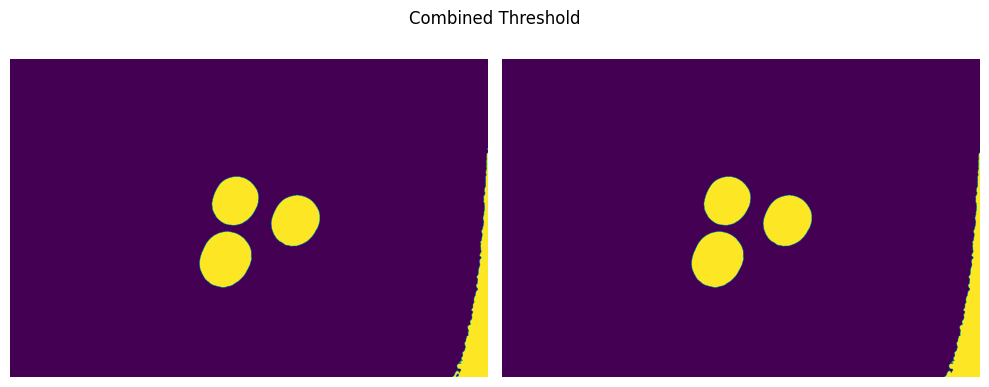

39 L1010382
hand


<Figure size 640x480 with 0 Axes>

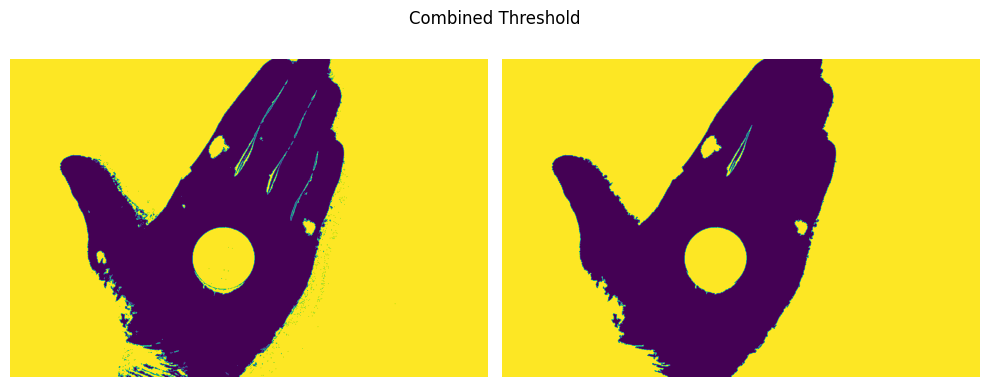

68 L1010491
noisy


<Figure size 640x480 with 0 Axes>

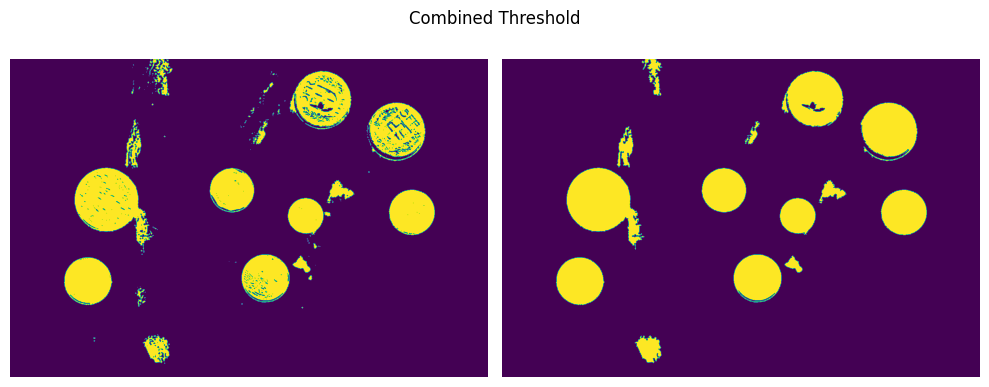

1 L1010298
neutral


<Figure size 640x480 with 0 Axes>

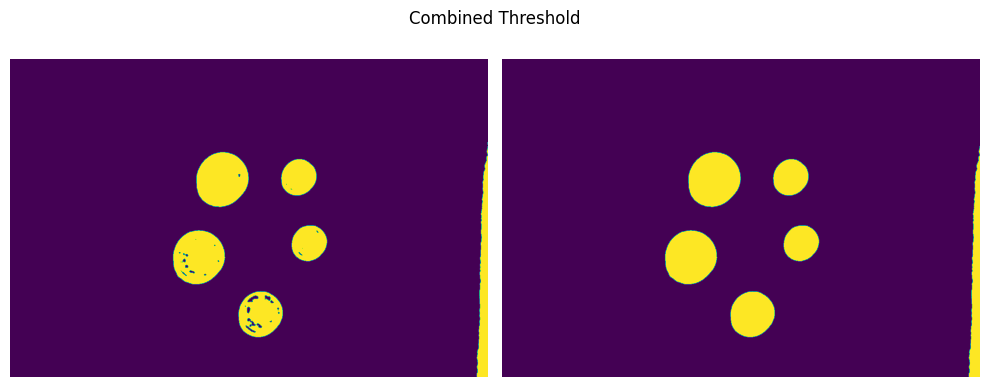

66 L1010503
noisy


<Figure size 640x480 with 0 Axes>

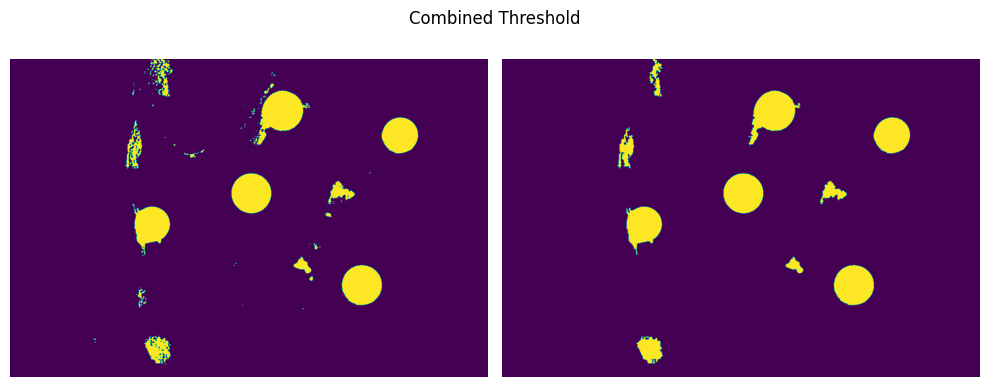

In [219]:
import random
list = random.sample(range(0,80),5)
print(list)

for i in list:
    print(i, coin_dataset.labels.iloc[i, 0])
    img_th = apply_threshold(img=coin_dataset[i]['image'])
    plot_thresholded_image(img=img_th, func=apply_morphology, title="Combined Threshold")